In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")
%pwd


'c:\\Users\\Bhavin\\Documents\\Project_1_Cancer_Classification'

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class PrepareBaseModelConfig:
    root_dir:Path
    base_model_path : Path
    updated_base_model_path : Path
    model_summary_image: Path
    params_image_size: list
    params_learning_rate: float
    params_include_top: bool
    params_weight:str
    params_classes: int
    

In [4]:
from src.cnnclassifier.constants import *
from src.cnnclassifier.utils.common import read_yaml,create_directories


In [5]:
from src.cnnclassifier.constants import *
from src.cnnclassifier.utils.common import read_yaml,create_directories
from src.cnnclassifier.entities.config_entity import *


class ConfigurationManager:
    def __init__(
        self,
        confif_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH) -> None:
        
        self.config = read_yaml(confif_filepath)
        self.params= read_yaml(params_filepath)
        # print(type([self.config.artifacts_root]))
        create_directories([self.config.artifacts_root])
        
    def get_data_ingestion_config(self)-> DataIngestionConfig:
        config = self.config.data_ingestion
        
        create_directories([config.root_dir])
        
        data_ingestion_config = DataIngestionConfig(
            root_dir=config.root_dir,
            source_URL=config.source_URL,
            local_data_file=config.local_data_file,
            unzip_dir=config.unzip_dir
        )
        
        return data_ingestion_config
    
    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model
        params = self.params
        create_directories([config.root_dir])
        
        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir=Path(config.root_dir),
            base_model_path=Path(config.base_model_path),
            updated_base_model_path=Path(config.updated_base_model_path),
            params_image_size=params.IAMGE_SIZE,
            params_learning_rate=params.LEARNING_RATE,
            params_classes=params.CLASSES,
            params_include_top=params.INCLUDE_TOP,
            params_weight=params.WEIGHTS,
            # model_summary_image=Path(config.updated_base_model_path),
            )
        
        return prepare_base_model_config

In [6]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten,Dense,Dropout

In [7]:

class PrepareBaseModel:
    def __init__(self,config: PrepareBaseModelConfig) -> None:
        self.config = config
        
    
    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,
            weights=self.config.params_weight,
            include_top= self.config.params_include_top
        )
        
        self.save_model(path=self.config.base_model_path,model=self.model)

        return self.model
    @staticmethod
    def _prepare_full_model(model,classes,freeze_till,learning_rate,freeze_all=False):
        if freeze_all:
            model.trainable=False
        if (freeze_till is not None) and (freeze_till>0):
            i=0
            while freeze_till:
                layer = model.layers[-i]
                if 'conv' in layer.name:
                    print(layer.name)
                    layer.trainable=True
                    freeze_till-=1
                i+=1
                
        
        flatten_in = Flatten()(model.output)
        dense1 = Dense(
            units=32,
            activation='relu'
        )(flatten_in)
        drop1 = Dropout(0.2)(dense1)
        
        prediction = Dense(
            classes,
            activation='softmax'
        )(drop1)
            
        full_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=prediction,
        )
        
        full_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        
        print(full_model.summary())
        
        return full_model
    
    def update_base_model(self):
        self.full_model = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_till=3,
            learning_rate=self.config.params_learning_rate,
            freeze_all=True
            
        )
        keras.utils.plot_model(
        self.full_model,
        # to_file=self.config.updated_base_model_path,
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=200,
        show_layer_activations=True,
        show_trainable=True,
    )
        
        self.save_model(path=self.config.updated_base_model_path,model=self.full_model)
        return self.full_model
    @staticmethod
    def save_model(path: Path,model : tf.keras.Model):
        model.save(path)

In [8]:
from src.cnnclassifier import CustomException,logger
import sys
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_base_model_config()
    prepare_base_model = PrepareBaseModel(config=prepare_base_model_config)
    tmp_model=prepare_base_model.get_base_model()
    my_model=prepare_base_model.update_base_model()
except Exception as e:
    raise CustomException(e,sys)

[2025-06-12 12:46:12,306] [INFO] [common:77] - yaml file:config\config.yaml loaded successfully
[2025-06-12 12:46:12,309] [INFO] [common:77] - yaml file:params.yaml loaded successfully
[2025-06-12 12:46:12,312] [INFO] [common:95] - artifacts directory is created
[2025-06-12 12:46:12,313] [INFO] [common:95] - artifacts/prepare_base_model directory is created
block5_conv3
block5_conv2
block5_conv1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,517,668 (59.20 MB)

 Trainable params: 7,882,404 (30.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None


In [9]:
for layer in my_model.layers:
    if layer.trainable:
        print(layer.name,end=" ")
        print(layer.count_params())

block5_conv1 2359808
block5_conv2 2359808
block5_conv3 2359808
flatten 0
dense 802848
dropout 0
dense_1 132


In [10]:
tmp_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

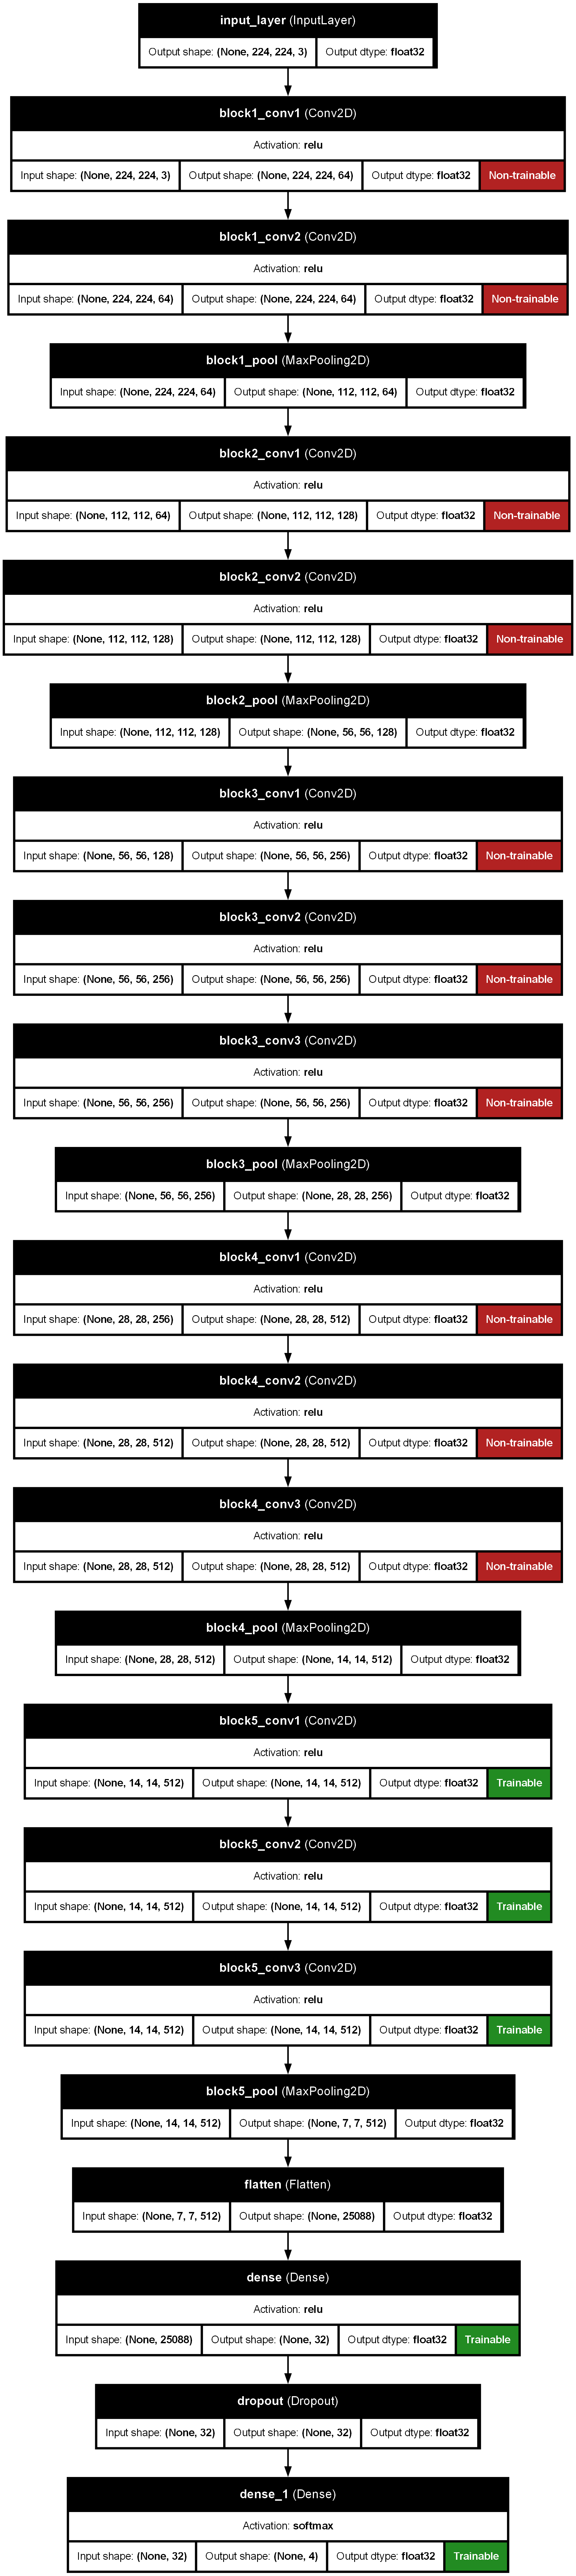

In [11]:
keras.utils.plot_model(
    my_model,
    to_file="artifacts/model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [12]:
my_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,517,668 (59.20 MB)

 Trainable params: 7,882,404 (30.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [16]:
import io
import logging

# Create a string buffer
stream = io.StringIO()

# Pass the buffer to model.summary() print_fn argument
my_model.summary(print_fn=lambda x: stream.write(x + '\n'))

# Get the string from the buffer
summary_str = stream.getvalue()

# Log it
logger.info("\n" + summary_str)

# Close the buffer
stream.close()


[2025-06-12 12:47:59,893] [INFO] [3605925865:14] - 
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├───

In [17]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras # type: ignore 
from tensorflow.keras.layers import Flatten,Dense,Dropout # type: ignore 
from pathlib import Path
from src.cnnclassifier.config.configuration import ConfigurationManager
from src.cnnclassifier.entities.config_entity import PrepareBaseModelConfig
from src.cnnclassifier import logger,CustomException
import io
class PrepareBaseModel:
    def __init__(self,config: PrepareBaseModelConfig=ConfigurationManager().get_prepare_base_model_config()) -> None:# type: ignore 
        self.config = config
        
    
    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,
            weights=self.config.params_weight,
            include_top= self.config.params_include_top
        )
        
        self.save_model(path=self.config.base_model_path,model=self.model)

        return self.model
    @staticmethod
    def _prepare_full_model(model,classes,freeze_till,learning_rate,freeze_all=False):
        if freeze_all:
            model.trainable=False
        if (freeze_till is not None) and (freeze_till>0):
            i=0
            while freeze_till:
                layer = model.layers[-i]
                if 'conv' in layer.name:
                    print(layer.name)
                    layer.trainable=True
                    freeze_till-=1
                i+=1
                
        
        flatten_in = Flatten()(model.output)
        dense1 = Dense(
            units=32,
            activation='relu'
        )(flatten_in)
        drop1 = Dropout(0.2)(dense1)
        
        prediction = Dense(
            classes,
            activation='softmax'
        )(drop1)
            
        full_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=prediction,
        )
        
        full_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        
        # Create a string buffer
        stream = io.StringIO()

        # Pass the buffer to model.summary() print_fn argument
        full_model.summary(print_fn=lambda x: stream.write(x + '\n'))

        # Get the string from the buffer
        summary_str = stream.getvalue()

        # Log it
        print(summary_str)
        logger.info("\n" + summary_str)

        # Close the buffer
        stream.close()
        
        
        return full_model
    
    def update_base_model(self):
        self.full_model = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_till=3,
            learning_rate=self.config.params_learning_rate,
            freeze_all=True
            
        )
        keras.utils.plot_model(
        self.full_model,
        to_file="artifacts/model.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=200,
        show_layer_activations=True,
        show_trainable=True,
    )
        
        self.save_model(path=self.config.updated_base_model_path,model=self.full_model)
        return self.full_model
    @staticmethod
    def save_model(path: Path,model : tf.keras.Model):
        model.save(path)

[2025-06-12 13:10:41,130] [INFO] [common:77] - yaml file:config\config.yaml loaded successfully
[2025-06-12 13:10:41,135] [INFO] [common:77] - yaml file:params.yaml loaded successfully
<class 'list'>
[2025-06-12 13:10:41,135] [INFO] [common:95] - artifacts directory is created
[2025-06-12 13:10:41,138] [INFO] [common:95] - artifacts/prepare_base_model directory is created


In [18]:
import sys
from src.cnnclassifier import logger,CustomException
from src.cnnclassifier.components.prepare_base_model import PrepareBaseModel
# from src.cnnclassifier.config.configuration import ConfigurationManager

STAGE_NAME = 'Prepare Base Model State'

class PrepareBaseModelPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        # config = ConfigurationManager()
        # data_ingestion_config = config.get_data_ingestion_config()
        prepare_base_model = PrepareBaseModel()
        prepare_base_model.get_base_model()
        prepare_base_model.update_base_model()
        
        
if __name__=="__main__":
    try:
        logger.info(f">>>>>>>>>> stage:{STAGE_NAME} started <<<<<<<<<<")
        obj = PrepareBaseModelPipeline()
        obj.main()
        logger.info(f">>>>>>>>>> stage:{STAGE_NAME} completed <<<<<<<<<<\n\n{'='*50}")

    except Exception as e:
        raise CustomException(e,sys)


[2025-06-12 13:11:11,619] [INFO] [common:77] - yaml file:config\config.yaml loaded successfully
[2025-06-12 13:11:11,622] [INFO] [common:77] - yaml file:params.yaml loaded successfully
<class 'list'>
[2025-06-12 13:11:11,623] [INFO] [common:95] - artifacts directory is created
[2025-06-12 13:11:11,623] [INFO] [common:95] - artifacts/prepare_base_model directory is created
[2025-06-12 13:11:11,625] [INFO] [3093648803:22] - >>>>>>>>>> stage:Prepare Base Model State started <<<<<<<<<<
block5_conv3
block5_conv2
block5_conv1


Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼───────────────────